# Kaggle Competition: Natural Language Processing with Disaster Tweets

### Author: Eric Caldwell 

* Presentation Type: Non-Technical

# Data Summary:

* The data contains information about tweets with the goal of predicting the presence of a natural disaster.
* Some tweets are not made in reference to a natural disaster, but some are legitimate. 
* The data has 7613 rows and 5 columns.




# Goals: 
* Compare the effectiveness of "first-pass" Machine Learning methodology vs raw natural language processing.
* Find the most important keywords.
* Find the best strategy between the two ("first-pass" ML and raw nlp).
* Bonus: Develop a process for finding keywords without the help of preprocessed training data.  


# Methods: 
* Bag-of-Words
* Word Tokenization
* Ridge Classification
* Naive-Bayes
* SVC
* Matplotlib/Seaborn

# Actionable Takeaway: There are 6 words/phrases that 100% indicate a real disaster. 

* Wreckage
* Debris
* Derailment
* oil%20spill
* suicide%20bomber
* suicide%20bombing

# Data Dictionary

* id - an identification number for every tweet (int64)
* __text - the tweet (object)__
* location - the location of the tweet (possible NaN) (object)
* __keyword - a keyword present in the tweet (possible NaN) (object)__
* __target - Present in train.csv only. Value is a 1 if the tweet is a real disaster and 0 if the tweet is not. (int64)__

In [38]:
# Import Cell

# Data Processing
import numpy as np 
import pandas as pd
from collections import Counter

# ML Formatting 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# ML Algorithms
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC

# ML Results
from sklearn.metrics import accuracy_score

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [39]:
# File Paths
train = r"/Users/eric_caldwell/Library/CloudStorage/OneDrive-UniversityofMountUnion/4th Year/DSC 440/nlp-getting-started/train.csv"
test = r"/Users/eric_caldwell/Library/CloudStorage/OneDrive-UniversityofMountUnion/4th Year/DSC 440/nlp-getting-started/test.csv"

In [40]:
# Load in the Data
df_train = pd.read_csv(train)
df_test = pd.read_csv(test)

# Data Exploration

In [41]:
# Let's see the first five rows
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [42]:
# Find the shape of the training and testing df

print("The train df has {0} rows and {1} columns.".format(df_train.shape[0], df_train.shape[1]))
print("\n")
print("The test df has {0} rows and {1} columns.".format(df_test.shape[0], df_test.shape[1]))

The train df has 7613 rows and 5 columns.


The test df has 3263 rows and 4 columns.


In [43]:
# Let's looks at the data types

print(df_train.dtypes)

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object


In [44]:
# Is the data clean?

print("Training df")
print(df_train.isnull().sum())
print("\n")
print("Testing df")
print(df_test.isnull().sum())

Training df
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


Testing df
id             0
keyword       26
location    1105
text           0
dtype: int64


In [45]:
# Clean up the data

df_train = df_train.dropna()
df_test = df_test.dropna()

## What does a real vs fake disaster tweet look like?

In [46]:
# Mask the training df for sample tweets

real_disaster = df_train[df_train["target"] == 1]
fake_disaster = df_train[df_train["target"] == 0]

In [47]:
# Show some sample tweets

print("Disaster tweet examples:")
print("\n")
print(real_disaster["text"].head())
print("\n")
print("Normal tweet examples:")
print("\n")
print(fake_disaster["text"].head())

Disaster tweet examples:


31    @bbcmtd Wholesale Markets ablaze http://t.co/l...
33    #AFRICANBAZE: Breaking news:Nigeria flag set a...
37    INEC Office in Abia Set Ablaze - http://t.co/3...
46    How the West was burned: Thousands of wildfire...
50    Deputies: Man shot before Brighton home set ab...
Name: text, dtype: object


Normal tweet examples:


32    We always try to bring the heavy. #metal #RT h...
34                   Crying out for more! Set me ablaze
35    On plus side LOOK AT THE SKY LAST NIGHT IT WAS...
36    @PhDSquares #mufc they've built so much hype a...
39                               Ablaze for you Lord :D
Name: text, dtype: object


In [48]:
# Find the character length of every tweet

# Only need to run the .insert method once per kernel

df_train.insert(4, "char_num", [len(i) for i in df_train['text']])
df_test.insert(4, "char_num", [len(i) for i in df_test['text']])

print(df_train.columns)
print(df_test.columns)

Index(['id', 'keyword', 'location', 'text', 'char_num', 'target'], dtype='object')
Index(['id', 'keyword', 'location', 'text', 'char_num'], dtype='object')


# What does the character length of the average tweet look like?

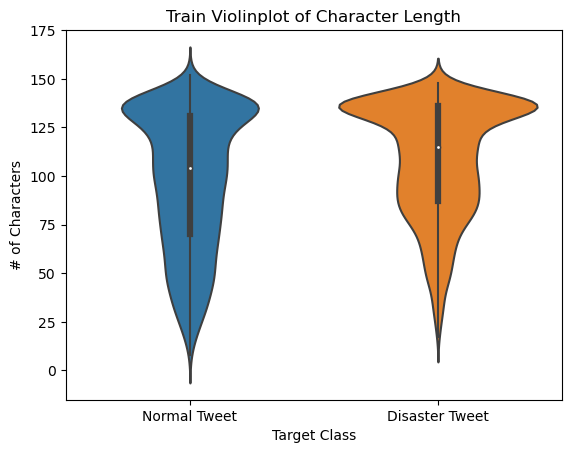

In [49]:
%matplotlib inline

# Using a violinplot due to the density of data provided (combines a kde and boxplot).
plt.figure()
sns.violinplot(x = "target",
               y = "char_num",
              data = df_train).set(title="Train Violinplot of Character Length",
                                   ylabel="# of Characters",
                                   xlabel="Target Class",
                                   xticklabels = ["Normal Tweet", "Disaster Tweet"])
plt.show()

### Both plots appear to have a peak probability around ~135 Characters

# What about the number of objects? (Defining objects as characters containing a space)

In [50]:
# All together

tweet_len=[]
print("Example: \n")
counter=0
# Loop through all tweets in the training df
for tweet in df_train["text"]: 
    # Lower all characters in the string
    low_tweet=tweet.lower()
    # Split a string into a list where each word is a list item
    split_tweet=low_tweet.split()
    # Count the length of the tweet
    c=Counter(split_tweet)
    num_obj=len(c)
    # Print out a few examples
    if counter<3:
        print(tweet, "\t", num_obj)
        print("\n")
    tweet_len.append(num_obj)
    counter+=1

Example: 

@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C 	 5


We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw 	 10


#AFRICANBAZE: Breaking news:Nigeria flag set ablaze in Aba. http://t.co/2nndBGwyEi 	 9




In [51]:
# By tweet classification (Real)

real_tweet_len=[]
for tweet in real_disaster["text"]: 
    low_tweet=tweet.lower()
    split_tweet=low_tweet.split()
    c=Counter(split_tweet)
    num_obj=len(c)
    real_tweet_len.append(num_obj)

In [52]:
# By tweet classification (Fake)

fake_tweet_len=[]
for tweet in fake_disaster["text"]: 
    low_tweet=tweet.lower()
    split_tweet=low_tweet.split()
    c=Counter(split_tweet)
    num_obj=len(c)
    fake_tweet_len.append(num_obj)

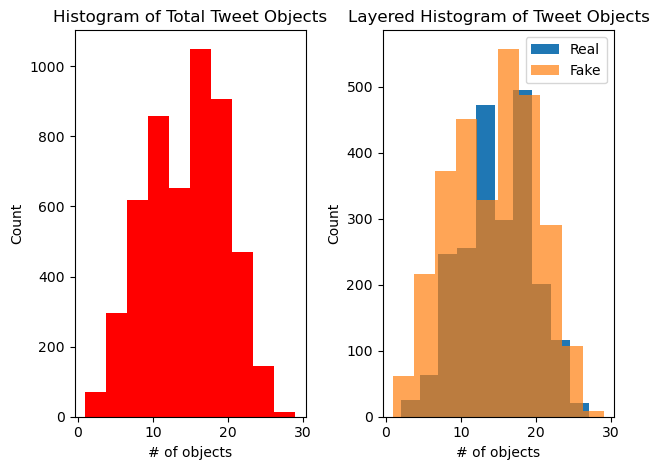

In [53]:
# Let's see the distribution of the tweet lengths using a histogram


# What do the lengths of the tweets look like as a whole?
plt.subplot(121)
plt.title("Histogram of Total Tweet Objects")
plt.ylabel("Count")
plt.xlabel("# of objects")
plt.hist(tweet_len, color='r')


# What happens to the histogram as we separate the tweets by type?
plt.subplot(122)
plt.title("Layered Histogram of Tweet Objects")
plt.hist(real_tweet_len, label="Real")
plt.hist(fake_tweet_len, label="Fake", alpha=0.7)
plt.ylabel("Count")
plt.xlabel("# of objects")
plt.legend()


plt.tight_layout()
plt.show()

# What are some of the Keywords?

In [54]:
# Print out the unique keywords from the df

print(df_train["keyword"].unique())

['ablaze' 'accident' 'aftershock' 'airplane%20accident' 'ambulance'
 'annihilated' 'annihilation' 'apocalypse' 'armageddon' 'army' 'arson'
 'arsonist' 'attack' 'attacked' 'avalanche' 'battle' 'bioterror'
 'bioterrorism' 'blaze' 'blazing' 'bleeding' 'blew%20up' 'blight'
 'blizzard' 'blood' 'bloody' 'blown%20up' 'body%20bag' 'body%20bagging'
 'body%20bags' 'bomb' 'bombed' 'bombing' 'bridge%20collapse'
 'buildings%20burning' 'buildings%20on%20fire' 'burned' 'burning'
 'burning%20buildings' 'bush%20fires' 'casualties' 'casualty'
 'catastrophe' 'catastrophic' 'chemical%20emergency' 'cliff%20fall'
 'collapse' 'collapsed' 'collide' 'collided' 'collision' 'crash' 'crashed'
 'crush' 'crushed' 'curfew' 'cyclone' 'damage' 'danger' 'dead' 'death'
 'deaths' 'debris' 'deluge' 'deluged' 'demolish' 'demolished' 'demolition'
 'derail' 'derailed' 'derailment' 'desolate' 'desolation' 'destroy'
 'destroyed' 'destruction' 'detonate' 'detonation' 'devastated'
 'devastation' 'disaster' 'displaced' 'drought' 

In [55]:
# Let's look at the most popular keywords!
# First, what are the most popular keywords in total.
# Second, what are the keywords from real disaster tweets.
# Third, what are the keywords from fake disaster tweets.

a=df_train["keyword"].value_counts()
b=real_disaster["keyword"].value_counts()
c=fake_disaster["keyword"].value_counts() 

# Convert the Indices to Lists
l1=a.index.tolist()
l2=b.index.tolist()
l3=c.index.tolist()

# Print the most popular keywords to the console
print("Overall Most Popular Keywords")
print(l1[0:5])
print('\n')
print("Real Disaster Most Popular Keywords")
print(l2[0:5])
print("\n")
print("Fake Disaster Most Popular Keywords")
print(l3[0:5])
print("\n")

# Let's see how many occurences of the keywords there were. 
print(a)
print("\n")
print(b)
print("\n")
print(c)


Overall Most Popular Keywords
['collision', 'whirlwind', 'armageddon', 'fatalities', 'flames']


Real Disaster Most Popular Keywords
['outbreak', 'wreckage', 'oil%20spill', 'collision', 'buildings%20on%20fire']


Fake Disaster Most Popular Keywords
['armageddon', 'ruin', 'harm', 'screaming', 'aftershock']


keyword
collision                36
whirlwind                33
armageddon               32
fatalities               32
flames                   31
                         ..
razed                    10
epicentre                 9
detonation                8
radiation%20emergency     6
inundation                5
Name: count, Length: 221, dtype: int64


keyword
outbreak                 30
wreckage                 28
oil%20spill              27
collision                26
buildings%20on%20fire    25
                         ..
blazing                   1
inundation                1
body%20bags               1
crush                     1
epicentre                 1
Name: count, Lengt

In [56]:
# Isolate the keywords and the target

df_kw = df_train[["keyword", "target"]]

# Group By the Keyword
grp = df_kw.groupby("keyword")
print(grp.head())

      keyword  target
31     ablaze       1
32     ablaze       0
33     ablaze       1
34     ablaze       0
35     ablaze       0
...       ...     ...
7544  wrecked       0
7545  wrecked       0
7547  wrecked       0
7548  wrecked       0
7552  wrecked       1

[1105 rows x 2 columns]


In [57]:
# Print Out Summary Statistics of the grouped keyword df

print(grp.describe())

                    target                                              
                     count      mean       std  min   25%  50%  75%  max
keyword                                                                 
ablaze                29.0  0.413793  0.501230  0.0  0.00  0.0  1.0  1.0
accident              28.0  0.750000  0.440959  0.0  0.75  1.0  1.0  1.0
aftershock            25.0  0.000000  0.000000  0.0  0.00  0.0  0.0  0.0
airplane%20accident   29.0  0.827586  0.384426  0.0  1.00  1.0  1.0  1.0
ambulance             26.0  0.461538  0.508391  0.0  0.00  0.0  1.0  1.0
...                    ...       ...       ...  ...   ...  ...  ...  ...
wounded               27.0  0.777778  0.423659  0.0  1.00  1.0  1.0  1.0
wounds                27.0  0.296296  0.465322  0.0  0.00  0.0  1.0  1.0
wreck                 27.0  0.148148  0.362014  0.0  0.00  0.0  0.0  1.0
wreckage              28.0  1.000000  0.000000  1.0  1.00  1.0  1.0  1.0
wrecked               22.0  0.090909  0.294245  0.0

In [58]:
# Find the mean of the grouped keyword df.
# Print the first 5 rows to the console.

grp_mn = grp.mean()
print(grp_mn.head())

                       target
keyword                      
ablaze               0.413793
accident             0.750000
aftershock           0.000000
airplane%20accident  0.827586
ambulance            0.461538


# The mean provides a solid estimate as to the effectiveness of the kw.
* __The higher the value, the more a keyword actually predicts a real disaster.__

In [59]:
# Sort the means from highest to lowest
# Grab only the fifty highest values.
# This is ideal for plotting as the more words are included harder it is to read the graph. 

data=grp_mn.sort_values(by="target", ascending=False)
data_short = data[0:50]

<Figure size 640x480 with 0 Axes>

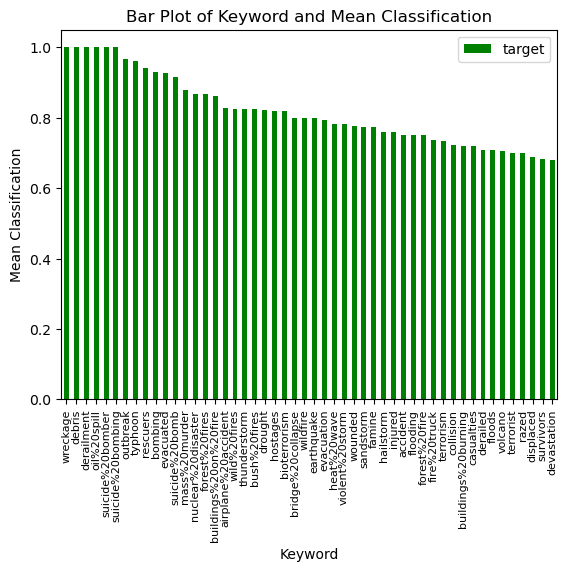

In [60]:
# Plot the means

plt.figure()
ax = data_short.plot.bar(color='g')
ax.set_title("Bar Plot of Keyword and Mean Classification")
ax.set_ylabel("Mean Classification")
ax.set_xlabel("Keyword")
ax.tick_params(axis="x", labelsize=8)

# There are 6 words/phrases that 100% indicate a real disaster.

* Wreckage
* Debris
* Derailment
* oil%20spill
* suicide%20bomber
* suicide%20bombing

# Is there an easier way to display this?

#### Hint: There is. 

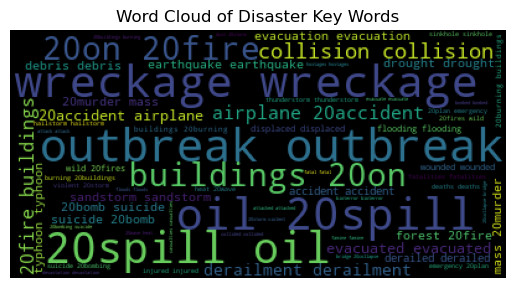

In [61]:
# Word Cloud

sting=""
for kw in real_disaster["keyword"]:
    sting += " "+kw+" "

#print(sting)

wordcloud=WordCloud().generate(sting)
plt.figure()
plt.title("Word Cloud of Disaster Key Words")
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# On to Machine Learning!

# Let's Build a Vector! (completing assignments with both magnitude and direction)

#### (Yes, this is a Despicable Me reference)

In [62]:
# Converts text into a matrix of token counts. 
# In this case all we care about is each word individually
c_v = CountVectorizer()
train_v = c_v.fit_transform(df_train["text"])
y = df_train['target']

In [63]:
# What do the feature names look like?
c_v.get_feature_names_out()

array(['00', '000', '0000', ..., 'ûó', 'ûóher', 'ûónegligence'],
      dtype=object)

# Ridge Classification

In [64]:
# Define the Classifier
clf = RidgeClassifier()

# Print the Scores to the Console
scores = cross_val_score(clf, train_v, y, cv=3, scoring='f1')
print("Scores: \n {0:.3f} \n {1:.3f} \n {2:.3f}".format(scores[0], scores[1], scores[2]))

Scores: 
 0.597 
 0.558 
 0.615


# Naive-Bayes

In [65]:
# Define the Classifier
clf=BernoulliNB()

# Print the Scores to the Console
scores = cross_val_score(clf, train_v, y, cv=3, scoring='f1')
print("Scores: \n {0:.3f} \n {1:.3f} \n {2:.3f}".format(scores[0], scores[1], scores[2]))

Scores: 
 0.618 
 0.634 
 0.715


# SVM

In [66]:
# Define the Classifier
model_svm = SVC(kernel="rbf", random_state=12)

# Print the Scores to the Console
scores = cross_val_score(model_svm, train_v, y, cv=3, scoring='f1')
print("Scores: \n {0:.3f} \n {1:.3f} \n {2:.3f}".format(scores[0], scores[1], scores[2]))

Scores: 
 0.608 
 0.572 
 0.651


# Results/Conclusion

* __Certain keywords are completely predictive of disaster.__
* __NLP/dataframe manipulation and intuition gives better insight than "first-pass" ML__ in my opinion.
* __Naive-Bayes__ was the best choice for a classification algorithm.

# Bonus:

## In the real world, data isn't so nicely formatted. We would be pulling tweets from an API.

## It's important to know how to find the keywords ourselves. 

# Brute Force Frequency of Words

In [67]:
# Bag of Words Method

# Grabbing the three most frequent words in a tweet
# Returns three tuples of (word, # number of occurrences)

common_words_train=[]
for tweet in df_train["text"]: 
    low_tweet=tweet.lower()
    split_tweet=low_tweet.split()
    c=Counter(split_tweet)
    ans=(c.most_common(3))
    common_words_train.append(ans)
common_words_train.sort()
print(common_words_train[0:50])

[[('!!!', 2), ('two', 1), ('great', 1)], [('#360wisenews', 1), (':', 1), ("china's", 1)], [('#360wisenews', 1), (':', 1), ("china's", 1)], [('#360wisenews', 1), (':', 1), ("china's", 1)], [('#360wisenews', 1), (':', 1), ("china's", 1)], [('#adani', 1), ('&amp;', 1), ('#modi', 1)], [('#africanbaze:', 1), ('breaking', 1), ('news:nigeria', 1)], [('#anthrax', 1), ('#bioterrorism', 1), ('cdc', 1)], [('#arsonist', 1), ('arrested', 1), ('for', 1)], [('#atk', 2), ('#letsfootball', 2), ('hermancranston:', 1)], [('#australia', 1), ('#news', 1), (';', 1)], [('#australia', 1), ('#news', 1), (';', 1)], [('#bangalore', 1), ('reddit', 1), ('updates', 1)], [('#battlefield', 1), ('1942', 1), ('forgotten', 1)], [('#bbshelli', 1), ('seems', 1), ('pretty', 1)], [('#bbsnews', 1), ('latest', 1), ('4', 1)], [('#bioterrorism', 1), ('authorities', 1), ('allay', 1)], [('#boulder', 1), ('deputies', 1), ('are', 1)], [('#breaking', 1), ('#news', 1), ('global', 1)], [('#breaking', 1), ('firefighters', 1), ('battlin

In [68]:
# Goal: sum the tuple values if the words are the same.

# Establish a dictionary
word_freq_dict = {}
# Loop through all list entries
for i in common_words_train:
    # Loop through all tuple entries
    for j in i:
        # If a word is in the dictionary already, add a value to the counter
        if j[0] in word_freq_dict.keys():
            word_freq_dict[j[0]] += j[1]
        # If the word is not in the dictionary, add it as a key and the counter as the value
        else:
            word_freq_dict[j[0]] = j[1]
        
# Grab the keys and values from the dict and zip them together
key_list = word_freq_dict.keys()
value_list = word_freq_dict.values()
eh = zip(key_list, value_list)

# Sort them from high to low and print out the 50 most common words.
freq_word = sorted(eh, key = lambda x: x[1])
freq_word.reverse()

print(freq_word[0:50])

[('the', 1163), ('a', 659), ('i', 546), ('to', 392), ('in', 351), ('of', 324), ('you', 257), ('and', 230), ('is', 198), ('my', 164), ('on', 142), ('-', 129), ('for', 127), ('this', 110), ('it', 109), ('that', 92), ('are', 85), ("i'm", 80), ('was', 80), ('just', 78), ('new', 72), ('your', 65), ('so', 62), ('at', 60), ('have', 59), ('he', 58), ('as', 58), ('|', 58), ('we', 56), ('if', 54), ('like', 53), ('with', 52), ('no', 51), ('police', 45), ('how', 44), ('fire', 44), ('man', 43), ('will', 42), ('from', 41), ('&amp;', 40), ('families', 39), ('what', 39), ('disaster', 38), ("it's", 38), ('when', 38), ('be', 37), ('now', 37), ('not', 36), ('they', 36), ('why', 36)]


In [69]:
# Reformat the data into a df for easier user interface
df = pd.DataFrame(key_list, columns=["word"])
df["count"] = value_list
df.head()

,word,count
0,!!!,2
1,two,28
2,great,12
3,#360wisenews,4
4,:,18


In [70]:
freq = []

# Sum the count
tot = df["count"].sum()

# Find the % of the word's usage
for w in df["count"]:
    perc = w / tot
    freq.append(perc)

# Add this column to the df
df["percentage_of_use"] = freq

# Sort by highest percentage of usage to the lowest. 
df_sort_perc = df.sort_values(by="percentage_of_use", ascending=False)

# Show the first five rows.
df_sort_perc.head()

,word,count,percentage_of_use
226,the,1163,0.063117
500,a,659,0.035765
270,i,546,0.029632
72,to,392,0.021274
69,in,351,0.019049


## Ideally, define a function to repeat for the different subset (real vs fake) data frames

In [71]:
# The End